In [4]:
import pandas as pd
import json 
from collections import *
from glob import glob
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
tqdm.pandas()

In [6]:
peft_dir = '/shared/2/projects/contextual-appropriateness/results/peft/'
long_df = pd.read_csv(peft_dir + 'all_rel_PRIDE.labeled.csv')
long_df.head()

,pride_id,text,relationship,answer,prediction
0,0,Rate whether it is inappropriate for this mess...,patient,yes,yes
1,0,Rate whether it is inappropriate for this mess...,neighbor,yes,yes
2,0,Rate whether it is inappropriate for this mess...,domestic_partner,yes,yes
3,0,Rate whether it is inappropriate for this mess...,sibling,yes,yes
4,0,Rate whether it is inappropriate for this mess...,boss,yes,yes


In [8]:
def to_long(sdf):
    d = {}
    for row in sdf.itertuples():
        d[row.relationship] = 1 if row.prediction == 'yes' else 0

    return pd.Series(d)

df = long_df.groupby('pride_id').progress_apply(to_long).reset_index()
df.head()

  0%|          | 0/47801 [00:00<?, ?it/s]

,pride_id,patient,neighbor,domestic_partner,sibling,boss,employee_in_large_company,married,teacher,law_enforcement,...,friend,mentee,friends_with_benefits,cousins,person_having_an_affair,lawyer,step_sibling,neice_nephew,coworker,divorcee
0,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df = df[df.columns[1:]].transpose()

In [13]:
df.shape

(49, 47801)

In [14]:
X = df.to_numpy()

In [26]:
tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=40)
z = tsne.fit_transform(X)

[t-SNE] Computing 48 nearest neighbors...
[t-SNE] Indexed 49 samples in 0.003s...
[t-SNE] Computed neighbors for 49 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 49 / 49
[t-SNE] Mean sigma: 36.812029
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.534832
[t-SNE] KL divergence after 1000 iterations: 0.330060


In [15]:
rel_to_cat = {'best friend': 'friend',
 'neighbor': 'friend',
 'friend': 'friend',
 'acquaintance': 'friend',
 'old friend': 'friend',
 'childhood friend': 'friend',
 'complete stranger': 'friend',
 'child': 'family',
 'parent': 'family',
 'grandparent': 'family',
 'sibling': 'family',
 'grandchild': 'family',
 'step sibling': 'family',
 'neice nephew': 'family',
 'cousins': 'family',
 'uncle aunt': 'family',
 'adopted child': 'family',
 'colleague': 'work',
 'coworker': 'work',
 'boss': 'work',
 'direct report': 'work',
 'employee in large company': 'work',
 'competitor': 'enemy',
 'rival': 'enemy',
 'enemy': 'enemy',
 'ex dating': 'romance',
 'engaged': 'romance',
 'divorcee': 'romance',
 'dating': 'romance',
 'person having an affair': 'romance',
 'married': 'romance',
 'domestic partner': 'romance',
 'friends with benefits': 'romance',
 'mentee': 'socialRole',
 'teacher': 'socialRole',
 'doctor': 'socialRole',
 'mentor': 'socialRole',
 'student': 'socialRole',
 'lawyer': 'socialRole',
 'patient': 'socialRole',
 'client': 'socialRole',
 'landlord': 'socialRole',
 'person with authority': 'socialRole',
 'law enforcement': 'socialRole',
 'classmate': 'teammate',
 'sports teammate': 'teammate',
 'club member': 'teammate',
 'fan': 'fan',
 'hero': 'fan'}
cat_to_rels = defaultdict(set)
for rel, cat in rel_to_cat.items():
    cat_to_rels[cat].add(rel)

In [16]:
renames = {
 'enemy': "Antagonist",
 'family': "Family",
 'fan': "Parasocial",
 'friend': "Social",
 'romance': "Romance",
 'socialRole': "Role-based",
 'teammate': "Peer-group",
 'work': "Organizational"    
}

In [87]:
sns.set(rc={'figure.figsize':(8, 8)})
sns.set_style('whitegrid')

[t-SNE] Computing 48 nearest neighbors...
[t-SNE] Indexed 49 samples in 0.004s...
[t-SNE] Computed neighbors for 49 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 49 / 49
[t-SNE] Mean sigma: 36.812029
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.534832
[t-SNE] KL divergence after 1000 iterations: 0.330060


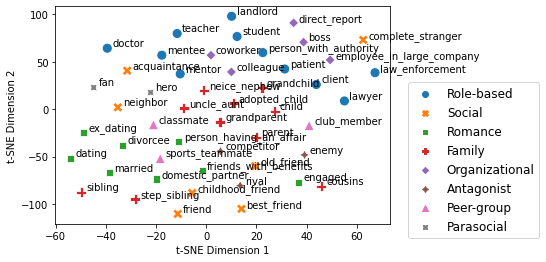

In [47]:
tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=40)
z = tsne.fit_transform(X)

tsne_df = pd.DataFrame()
#tsne_df["y"] = y
tsne_df["comp1"] = z[:,0]
tsne_df["comp2"] = z[:,1]
tsne_df["label"] = list(df.index)
tsne_df['Category'] = pca_df.label.apply(lambda x: renames[rel_to_cat[x.replace('_', ' ')]])


ax = sns.scatterplot(data=tsne_df, x="comp1", y="comp2",
                     hue='Category', style='Category', s=100)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+2, point['y']+2, str(point['val']))

label_point(tsne_df.comp1, tsne_df.comp2, tsne_df.label, plt.gca())  
#plt.annotate(df.rel, (tsne_df["comp-1"], tsne_df["comp-2"]), size=10, weight='bold', color='k') 


plt.legend(bbox_to_anchor=(1.25, .65), loc='upper center', 
           borderaxespad=0,  prop={'size': 12})
plt.savefig('../../plots/t-sne.flan-t5-xl.pdf', bbox_inches = "tight")

In [17]:
pca = PCA(n_components=4)
pca.fit(X)
Z = pca.transform(X)

In [18]:
pca.explained_variance_ratio_

array([0.54487114, 0.08812419, 0.03765981, 0.02818802])

In [19]:
def label_point(x, y, val, ax, offset=3):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + offset, point['y'], str(point['val'].replace('_', ' ')))

In [21]:
pca_df = pd.DataFrame()
#pca_df["y"] = y
pca_df["comp1"] = Z[:,0]
pca_df["comp2"] = Z[:,1]
pca_df["comp3"] = Z[:,2]
pca_df["comp4"] = Z[:,3]
pca_df["label"] = list(df.index)
pca_df['Category'] = pca_df.label.apply(lambda x: renames[rel_to_cat[x.replace('_', ' ')]])

#plt.annotate(df.rel, (pca_df["comp-1"], pca_df["comp-2"]), size=10, weight='bold', color='k') 
pca_df.head()


,comp1,comp2,comp3,comp4,label,Category
0,-67.608491,-18.089802,0.585263,-0.120064,patient,Role-based
1,-23.520224,36.837227,-3.968216,6.893352,neighbor,Social
2,79.959623,-13.475303,-6.994826,-12.992077,domestic_partner,Romance
3,92.814066,-30.994823,-25.233674,23.998925,sibling,Family
4,-77.496572,-34.782299,3.967902,-6.913194,boss,Organizational


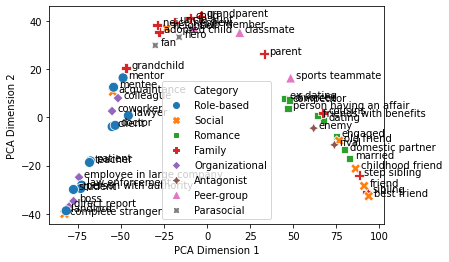

In [23]:
ax = sns.scatterplot(data=pca_df, x="comp1", y="comp2", hue='Category', 
                     style='Category', s=100)
#                     palette=sns.color_palette("crest", 3)).set(title="Relationships")

label_point(pca_df.comp1, pca_df.comp2, pca_df.label, plt.gca())  
#plt.legend(bbox_to_anchor=(.62, 1.05), loc='upper center', 
#           borderaxespad=0,  prop={'size': 16})

plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')

plt.savefig('../../plots/pca.v2.pdf', bbox_inches = "tight")

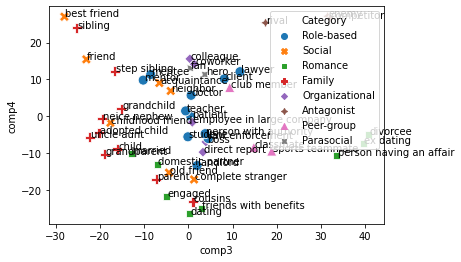

In [24]:
ax = sns.scatterplot(data=pca_df, x="comp3", y="comp4", hue='Category', 
                     style='Category', s=100)
label_point(pca_df.comp3, pca_df.comp4, pca_df.label, plt.gca(), offset=0.2)  